# NDVI computation with eodag


In this tutorial, we compute a bandmath on a Sentinel-2 source, directly by giving an extent with eodag. The area of interest is the center of Toulouse.

Let's start by setting your personal credentials to access [sobloo service](https://sobloo.eu/) by filling your api key bellow:

In [1]:
import os
os.environ["EODAG__SOBLOO__AUTH__CREDENTIALS__APIKEY"] = "<INSERT_API_KEY>"
os.environ["EODAG__SOBLOO__DOWNLOAD__OUTPUTS_PREFIX"] = "/home/sobloo/eodag_data"

Then we create a workspace directory where all our files and configuration will live:

In [2]:
from eodag.api.core import EODataAccessGateway
from eodag.utils.logging import setup_logging

workspace = 'eodag_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

# To have some basic feedback on what eodag is doing, we configure logging to output minimum information
setup_logging(verbose=1)
dag = EODataAccessGateway()
dag.set_preferred_provider("sobloo")

2020-10-30 09:31:28,846-15s eodag.config                     [INFO    ] Loading user configuration from: /home/sobloo/.config/eodag/eodag.yml


We define an extent and search for the same product type as in the previous tutorial for the entire month of May 2018:

In [3]:
product_type = 'S2_MSI_L1C'
extent = {
    'lonmin': 1.306000,
    'lonmax': 1.551819,
    'latmin': 43.527642,
    'latmax': 43.662905
}

products, estimated_nbr_of_results = dag.search(
    productType=product_type,
    start='2020-09-01',
    end='2020-10-29',
    box=extent,
    cloudCover=1
)
product = products[0]
product.properties['title']

2020-10-30 09:31:45,656-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: sobloo
2020-10-30 09:31:45,658-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://sobloo.eu/api/v1/services/search?f=identification.type:eq:S2MSI1C&f=contentDescription.cloudCoverPercentage:lte:1&f=acquisition.beginViewingDate:gte:1598918400000&f=acquisition.endViewingDate:lte:1603929600000&gintersect=1.306,43.527642,1.551819,43.662905&size=1&from=0
2020-10-30 09:31:46,148-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://sobloo.eu/api/v1/services/search?f=identification.type:eq:S2MSI1C&f=contentDescription.cloudCoverPercentage:lte:1&f=acquisition.beginViewingDate:gte:1598918400000&f=acquisition.endViewingDate:lte:1603929600000&gintersect=1.306,43.527642,1.551819,43.662905&size=20&from=0
2020-10-30 09:31:46,610-15s eodag.core                       [INFO    ] Found 1 result(s) on provider 'sobloo'


'S2B_MSIL1C_20200902T104629_N0209_R051_T31TCJ_20200902T121149'

The method **get_data** allows us to directly retrieve a subset of the EO product without downloading it if it has already been downloaded. If it has not, it is first downloaded locally and then the subset is retrieved. In the final version of eodag, this retrieval will be done without the entire product downloaded locally.

In [4]:
VIR = product.get_data(crs='epsg:4326', resolution=0.0001, band='B04', extent=(1.435905, 43.586857, 1.458907, 43.603827))
NIR = product.get_data(crs='epsg:4326', resolution=0.0001, band='B08', extent=(1.435905, 43.586857, 1.458907, 43.603827))
NDVI = (NIR - VIR * 1.) / (NIR + VIR)

2020-10-30 09:31:50,217-15s eodag.api.product                [WARNING ] Eodag does not support getting data from distant sources by now. Falling back to first downloading the product and then getting the data...
2020-10-30 09:31:50,219-15s eodag.plugins.download.http      [INFO    ] Download url: https://sobloo.eu/api/v1/services/download/a00c856a-e2a2-4075-b983-b4ea6c627685
843MB [01:59, 1.10MB/s] 2020-10-30 09:33:50,641-15s eodag.plugins.download.http      [INFO    ] Extraction activated

Extracting files from S2B_MSIL1C_20200902T104629_N0209_R051_T31TCJ_20200902T121149.zip:   0%|          | 0/115 [00:00<?, ?file/s]
Extracting files from S2B_MSIL1C_20200902T104629_N0209_R051_T31TCJ_20200902T121149.zip:  14%|█▍        | 16/115 [00:00<00:00, 120.48file/s]
Extracting files from S2B_MSIL1C_20200902T104629_N0209_R051_T31TCJ_20200902T121149.zip:  17%|█▋        | 20/115 [00:01<00:11,  8.33file/s] 
Extracting files from S2B_MSIL1C_20200902T104629_N0209_R051_T31TCJ_20200902T121149.zip:  20%|█

Now we can plot the result and see in green the "Prairie des Filtres" on the left, and "Grand-Rond"-"Jardin des plantes" parks on the right center. In red, the "Garonne".
We also save this picture and share it with who we want!

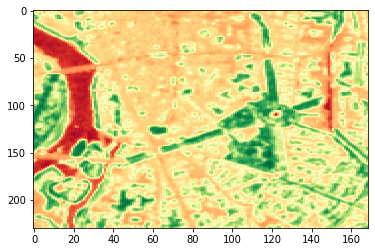

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(NDVI, cmap='RdYlGn', aspect='auto')
plt.savefig(os.path.join(workspace, 'ndvi_toulouse.png'))
plt.show()